In [1]:
# Imports.
import matplotlib.pyplot as plt
from skimage import io
import pandas as pd
import os
import yaml
import matplotlib
import numpy as np
font = {'size'   : 14}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
# Input directories, colors & files.
data = {'+ATP': (r'figure_data/WT CMG/ATP/', 'tab:blue', 'white'),
        'No nucleotide': (r'figure_data/WT CMG/no_nucleotide/', 'tab:orange', 'white'),
        '+ATPgS': (r'figure_data/WT CMG/ATPgS/', 'mediumpurple', 'white'),
        'dCas9': (r'figure_data/dCas9/', 'gray', 'white')}
files = {'cpa': 'cpa_result.yaml',
         'msd': 'msd_result.yaml',
         'motion': 'summary_table.csv',
         'traces': 'filtered_traces_drift_corrected_steps-not-divided.csv'}
cpa_v_threshold_dcas9 = 0.4 * 5

# CHANGE THIS PATH TO THE PATH TO THE REPOSITORY
# REPOSITORY AVAILABLE AT https//doi.org/10.4121/19948253
repository_directory = r'M:\tnw\bn\nd\Shared\Daniel\Manuscripts\2022 CMG activation paper data and analysis\RamirezMontero et al_NatComm_2023_data'

In [3]:
# Helper functions.
def dropna(arr):
    return arr[~np.isnan(arr)]

In [4]:
def plot_alpha(df_motion, title, color, edgecolor, ax=None):
    
    anom_diff_exp = df_motion['alpha']
    moving = np.array(df_motion['moving'], dtype=bool)
    plot_exp = anom_diff_exp[moving]
    plot_exp = dropna(plot_exp)
    
    bin_width = 2/8
    hist_bins = np.array([bin_width * i for i in range(9)])
    hist, _ = np.histogram(plot_exp, bins=hist_bins)
    
    if ax is None:
        fig, ax = plt.subplots()
    ax.bar(hist_bins[:-1] + bin_width/2, hist / len(anom_diff_exp), width=bin_width, 
        color=color, edgecolor=edgecolor, linewidth=1.5)
    ax.set_ylabel('Fraction of total traces')
    ax.set_xlabel('α')
    ax.set_ylim(0, 0.5)
    ax.axvline(0, c='k', linestyle='dashed')
    ax.axvline(0.5, c='k', linestyle='dashed')
    ax.axvline(1.5, c='k', linestyle='dashed')
    ax.axvline(2, c='k', linestyle='dashed')
    ax.text(0.25, 0.45, 'SubD.', horizontalalignment='center', fontsize=10)
    ax.text(1, 0.45, 'Diff.', horizontalalignment='center', fontsize=10)
    ax.text(1.75, 0.45, 'SuperD.', horizontalalignment='center', fontsize=10)
    ax.text(1, 0.3, 'N = '+str(len(moving[moving]))+'\nmobile traces', horizontalalignment='center', fontsize=10)
    if ax is None:
        plt.title(title + ', non-static')
        plt.show()
        plt.close()

In [5]:
# Plot absolute velocity of superdiffusive traces.
def plot_abs_velocity(df_motion, cpa_dict, title, color, edgecolor, ax=None, ymax=0.7):
    
    anom_diff_exp = np.array(df_motion['alpha'])
    moving_list = np.array(df_motion['moving'], dtype=bool)
    v_list = []
    for idx, cpa_info in cpa_dict.items():
        v_list.append(cpa_info['v_fit'])
    
    v_abs_plot = np.array([])
    for v_arr, moving, alpha in zip(v_list, moving_list, anom_diff_exp):
        if (moving) & (alpha >= 1.5):
            v_abs_plot = np.concatenate((v_abs_plot, 1000 * np.absolute(v_arr)))
    hist_bins = np.arange(0, 50, 2.5)
    yabs, xabs = np.histogram(v_abs_plot, bins=hist_bins)
    
    if ax is None:
        fig, ax = plt.subplots()
    ax.bar(xabs[:-1] + 2.5/2, yabs/len(v_abs_plot), width=2.5, color=color, edgecolor=edgecolor, linewidth=1.5)
    ax.set_ylabel('Fraction')
    ax.set_xlabel('Absolute instantaneous velocity (bp/s)')
    ax.set_ylim(0, ymax)
    ax.set_yticks(np.arange(0, ymax+0.001, 0.1))
    if ax is None:
        plt.title(title + ', α ≥ 1.5')
        plt.show()
        plt.close()
        

In [6]:
def diffusion_panel(D_plot, title, color, edgecolor, n):

    hist_bins = np.array([10**i for i in np.arange(-8, 0, 0.5)])
    log_bins = np.array([i for i in np.arange(-8, 0, 0.5)])
    hist, _ = np.histogram(D_plot, bins=hist_bins)
    plt.bar(log_bins[:-1] + 0.25, hist/n, width=0.5, color=color, edgecolor=edgecolor, linewidth=1.5)
    plt.title(title + ', N=' + str(len(D_plot)))
    plt.xlabel('diffusion (kbp^2/s)')
    plt.ylabel('fraction')
    plt.xticks([-7, -6, -5, -4, -3, -2, -1], ['1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '1e-1'])
    plt.xlim(-7.5, -0.5)
    plt.ylim(0, 0.5)
    plt.axvline(np.mean(np.log10(D_plot)), c='k', linestyle='dashed')
    plt.show()
    plt.close()
    
def plot_diffusion(df_motion, title, color, edgecolor):
    
    anom_diff_exp = df_motion['alpha']
    diff_D = df_motion['diffusion (kbp**2/s)']
    moving_list = np.array(df_motion['moving'], dtype=bool)
    
    D_all = dropna(diff_D)
    D_plot = np.array([])
    for D, moving, alpha in zip(diff_D, moving_list, anom_diff_exp):
        if (moving) & (alpha >= 0.5) & (alpha < 1.5):
            D_plot = np.concatenate((D_plot, [D]))
    D_plot = dropna(D_plot)
    
    diffusion_panel(D_plot, title + ', 0.5 ≤ α < 1.5', color, edgecolor, n=len(D_all))
    diffusion_panel(D_all, title, color, edgecolor, n=len(D_all))

[0.3255814  0.02325581 0.18604651 0.46511628] [0.07145956 0.02298381 0.05934393 0.07606349]
0 / 43  uncategorized
[0.58333333 0.05555556 0.27777778 0.08333333] [0.08216777 0.0381769  0.07465053 0.04606423]
0 / 36  uncategorized
[0.82352941 0.         0.         0.17647059] [0.0653787 0.        0.        0.0653787]
0 / 34  uncategorized
[1. 0. 0. 0.] [0. 0. 0. 0.]
0 / 23  uncategorized


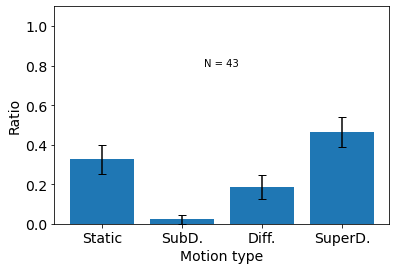

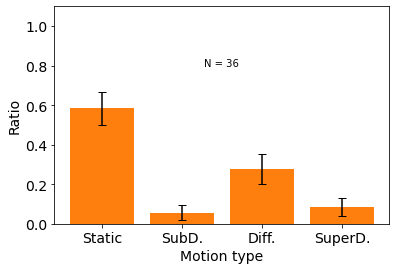

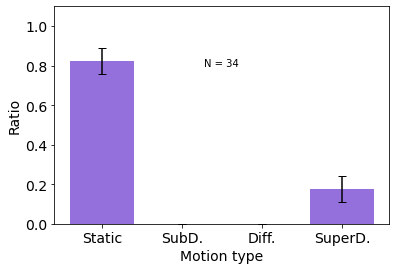

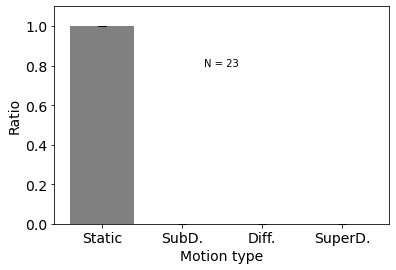

In [7]:
def plot_motion_type_histogram(df_motion, title, color, edgecolor, ax=None, mobile_only=False):
    
    anom_diff_D = np.array(df_motion['anomalous diffusion'])
    anom_diff_exp = np.array(df_motion['alpha'])
    moving_list = np.array(df_motion['moving'], dtype=bool)

    anom_diff_exp_m = anom_diff_exp[moving_list]
    static = len(moving_list[~moving_list])
    subD = len(anom_diff_exp_m[anom_diff_exp_m < 0.5])
    diffD = len(anom_diff_exp_m[(anom_diff_exp_m >= 0.5) & (anom_diff_exp_m < 1.5)])
    superD = len(anom_diff_exp_m[anom_diff_exp_m >= 1.5])
    n = static + subD + diffD + superD
    n_nan = len(moving_list) - n

    if ax is None:
        fig, ax = plt.subplots()
        
    if not mobile_only:
        x = [0, 1, 2, 3]
        y = np.array([static / n,
                      subD / n,
                      diffD / n,
                      superD / n])
        yerr = np.sqrt(y * (1 - y) / n)
        ax.text(1.5, 0.8, 'N = '+str(n), horizontalalignment='center', fontsize=10)
        ax.set_xticks([0, 1, 2, 3])
        ax.set_xticklabels(["Static", "SubD.", "Diff.", "SuperD."])
    else:
        n = subD + diffD + superD
        x = [0, 1, 2]
        y = np.array([subD / n,
                      diffD / n,
                      superD / n])
        yerr = np.sqrt(y * (1 - y) / n)
        ax.text(1.5, 0.8, 'N = '+str(n), horizontalalignment='center', fontsize=10)
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(["SubD.", "Diff.", "SuperD."])
    
    print(y, yerr)
    print(n_nan, '/', len(moving_list), ' uncategorized')
    ax.bar(x, y, color=color, yerr=yerr, capsize=4)
    ax.set_ylabel('Ratio')
    ax.set_xlabel('Motion type')
    ax.set_ylim(0, 1.1)
    if ax is None:
        plt.show()
        plt.close()
        
for name, params in data.items():
    df_motion = pd.read_csv(os.path.join(params[0], files['motion']))
    plot_motion_type_histogram(df_motion, name, params[1], params[2])

posx and posy should be finite values
posx and posy should be finite values


[-3.0994798640570984, -2.8542866397817175, nan, -4.645354388397998]


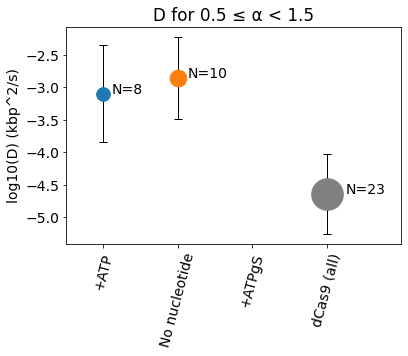

[-2.974652517035827, -2.5636907564892106, nan, -4.622078909000589]


posx and posy should be finite values
posx and posy should be finite values


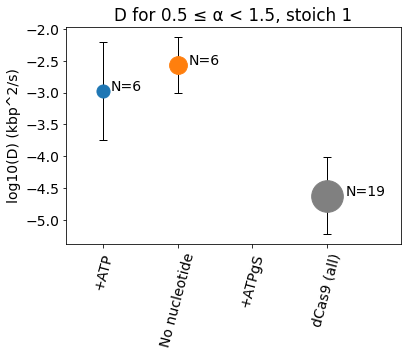

In [8]:
# Diffusion coefficient vs condition (all stoichiometries & stoichiometry 1).
def plot_diff_vs_cond(title, means, stds, sizes, colors, counts, labels):
    n = len(means)
    plt.figure()
    plt.errorbar(np.arange(n), means, yerr=stds, linewidth=0, elinewidth=1, capsize=4, c='k', zorder=1)
    print(means)
    for i in range(n):
        plt.scatter([i], [means[i]], c=colors[i], s=1000 * sizes[i], zorder=2)
        plt.text(i + np.sqrt(sizes[i])/4, means[i], 'N='+str(counts[i]))
    plt.xticks(np.arange(n), labels, rotation=75)
    plt.ylabel('log10(D) (kbp^2/s)')
    plt.xlim(-0.5, n)
    plt.title(title)
    plt.show()
    plt.close()
    
# Compile data.
means = []
stds = []
sizes = []
colors = []
labels = []
counts = []
for name, params in data.items():
    df_motion = pd.read_csv(os.path.join(params[0], files['motion']))
    if not name == 'dCas9':
        df_diff = df_motion[(df_motion['alpha'] >= 0.5) & (df_motion['alpha'] < 1.5)]
        labels.append(name)
    else:
        df_diff = df_motion
        labels.append('dCas9 (all)')
    colors.append(params[1])
    means.append(np.log10(df_diff['diffusion (kbp**2/s)']).mean())
    stds.append(np.log10(df_diff['diffusion (kbp**2/s)']).std())
    sizes.append(len(df_diff) / len(df_motion))
    counts.append(len(df_diff))
plot_diff_vs_cond('D for 0.5 ≤ α < 1.5', means, stds, sizes, colors, counts, labels)

# Compile data for stoichiometry one.
means = []
stds = []
sizes = []
colors = []
labels = []
counts = []
for name, params in data.items():
    df_motion = pd.read_csv(os.path.join(params[0], files['motion']))
    df_motion = df_motion[df_motion['stoichiometry'] == 1]
    if not name == 'dCas9':
        df_diff = df_motion[(df_motion['alpha'] >= 0.5) & (df_motion['alpha'] < 1.5)]
        labels.append(name)
    else:
        df_diff = df_motion
        labels.append('dCas9 (all)')
    colors.append(params[1])
    means.append(np.log10(df_diff['diffusion (kbp**2/s)']).mean())
    stds.append(np.log10(df_diff['diffusion (kbp**2/s)']).std())
    sizes.append(len(df_diff) / len(df_motion))
    counts.append(len(df_diff))
plot_diff_vs_cond('D for 0.5 ≤ α < 1.5, stoich 1', means, stds, sizes, colors, counts, labels)

In [9]:
# Stoichiometry vs alpha.
def stoich_vs_alpha(df_motion, title, color):
    df_moving = df_motion[df_motion['moving'].astype(bool)]
    plt.scatter(df_moving['stoichiometry'], df_moving['alpha'], c=color)
    plt.title(title)
    plt.xlabel('stoichiometry')
    plt.ylabel('α')
    plt.xlim(0.5, 10.5)
    plt.ylim(-0.1, 2.1)
    plt.show()
    plt.close()

In [10]:
# Plot traces with CPA.
def plot_cpa(df_motion, df_traces, cpa_dict, title, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 16))
    for scan_id, scan in df_traces.groupby('scan_id'):
        for trace_id, trace in scan.groupby('trace_id'):
            motion_data = df_motion[(df_motion['scan_id'] == scan_id) & (df_motion['trace_id'] == trace_id)].iloc[0]
            cpa_data = cpa_dict[(int(scan_id), int(trace_id))]
            moving = bool(motion_data['moving'])
            x_fit = cpa_data['x_fit']
            v = cpa_data['v_fit']
            p = cpa_data['jumps']
            if moving:
                ax.scatter(trace['time_s'], trace['x_kbp'], zorder=2, s=10)
                for p_index in range(len(p) - 2):
                    start = p[p_index]
                    end = p[p_index + 1]
                    ax.plot(np.array(trace['time_s'])[start:end], x_fit[start:end], zorder=2, c='k', linewidth=0.5)
                    ax.plot(np.array(trace['time_s'])[end - 1:end + 3], x_fit[end - 1:end + 3], zorder=2, c='k',
                            linestyle='dotted', linewidth=0.5)
                ax.plot(np.array(trace['time_s'])[p[-2]:p[-1]], x_fit[p[-2]:p[-1]], zorder=2, c='k', linewidth=0.5)
            else:
                ax.scatter(trace['time_s'], trace['x_kbp'], color=(0.8, 0.8, 0.8, 1), zorder=1, s=10)
                for p_index in range(len(p) - 2):
                    start = p[p_index]
                    end = p[p_index + 1]
                    ax.plot(np.array(trace['time_s'])[start:end], x_fit[start:end], color=(0.8, 0.8, 0.8, 1), zorder=1, 
                            linewidth=0.5)
                    ax.plot(np.array(trace['time_s'])[end - 1:end + 3], x_fit[end - 1:end + 3],
                            color=(0.8, 0.8, 0.8, 1), zorder=1, linestyle='dotted', linewidth=0.5)
                ax.plot(np.array(trace['time_s'])[p[-2]:p[-1]], x_fit[p[-2]:p[-1]], color=(0.8, 0.8, 0.8, 1), zorder=1, 
                        linewidth=0.5)
    ax.set_ylim(0, df_traces['dna_length_kbp'].iloc[0])
    ax.set_ylabel('x (kbp)')
    ax.set_xlabel('t (s)')
    ax.set_xlim(0, 750)
    ax.text(500, 21, 'N = ' + str(len(df_motion)), fontsize=10)
    if ax is None:
        plt.show()
        plt.close()

In [11]:
# Abs mean velocity of superdiffusive traces.
def plot_abs_mean_velocity(df_motion, cpa_dict, title, color, edgecolor, ax=None):
    
    v_all = np.array([])
    v_static = np.array([])
    abs_mean_v = []
    abs_mean_v_superdiff = []
    all_abs_v_superdiff = []
    abs_mean_v_static = []
    v_weight = []
    v_weight_superdiff = []
    v_weight_static = []
    
    for key, cpa_data in cpa_dict.items():
        v_all = np.concatenate((v_all, cpa_data['v_fit']))
        scan_id, trace_id = key
        motion_data = df_motion[(df_motion['scan_id'] == scan_id) & (df_motion['trace_id'] == trace_id)].iloc[0]
        abs_mean_v.append(np.absolute(np.mean(cpa_data['v_fit'])))
        v_weight.append(len(cpa_data['v_fit']))
        if bool(motion_data['moving']) and motion_data['alpha'] >= 1.5:
            abs_mean_v_superdiff.append(np.absolute(np.mean(cpa_data['v_fit'])))
            v_weight_superdiff.append(len(cpa_data['v_fit']))
            all_abs_v_superdiff = all_abs_v_superdiff + [abs_mean_v_superdiff[-1] for _ in range(v_weight_superdiff[-1])]
    
    v_bins = np.array([i * 1 for i in range(25)])
    if ax is None:
        fig, ax = plt.subplots()
    ax.hist(1000*np.array(abs_mean_v_superdiff), weights=v_weight_superdiff / np.sum(v_weight_superdiff), 
            bins=v_bins, color=color, edgecolor=edgecolor, linewidth=1.5)
    ax.set_ylabel('Weighted frequency')
    ax.set_xlabel('Absolute mean velocity (bp/s)')
    if ax is None:
        plt.title(title + ", non-static traces")
        plt.show()
        plt.close()
        
# Abs mean velocity of nonstatic traces.
def plot_abs_mean_velocity_nonstatic(df_motion, cpa_dict, title, color, edgecolor, ax=None):
    
    v_all = np.array([])
    v_static = np.array([])
    abs_mean_v = []
    abs_mean_v_nonstatic = []
    all_abs_v_nonstatic = []
    abs_mean_v_static = []
    v_weight = []
    v_weight_nonstatic = []
    v_weight_static = []
    
    for key, cpa_data in cpa_dict.items():
        v_all = np.concatenate((v_all, cpa_data['v_fit']))
        scan_id, trace_id = key
        motion_data = df_motion[(df_motion['scan_id'] == scan_id) & (df_motion['trace_id'] == trace_id)].iloc[0]
        abs_mean_v.append(np.absolute(np.mean(cpa_data['v_fit'])))
        v_weight.append(len(cpa_data['v_fit']))
        if bool(motion_data['moving']):
            abs_mean_v_nonstatic.append(np.absolute(np.mean(cpa_data['v_fit'])))
            v_weight_nonstatic.append(len(cpa_data['v_fit']))
            all_abs_v_nonstatic = all_abs_v_nonstatic + [abs_mean_v_nonstatic[-1] for _ in range(v_weight_nonstatic[-1])]
        else:
            v_static = np.concatenate((v_static, cpa_data['v_fit']))
            abs_mean_v_static.append(np.absolute(np.mean(cpa_data['v_fit'])))
            v_weight_static.append(len(cpa_data['v_fit']))
    
    v_bins = np.array([i * 1 for i in range(25)])
    if ax is None:
        fig, ax = plt.subplots()
    ax.hist(1000*np.array(abs_mean_v_nonstatic), weights=v_weight_nonstatic / np.sum(v_weight_nonstatic), 
            bins=v_bins, color=color, edgecolor=edgecolor, linewidth=1.5)
    ax.set_ylabel('Weighted frequency')
    ax.set_xlabel('Absolute mean velocity (bp/s)')
    if ax is None:
        plt.title(title + ", non-static traces")
        plt.show()
        plt.close()
        
# Inst velocities.
def plot_cpa_velocity_all(df_motion, cpa_dict, title, color, edgecolor, ax=None, text='inside'):
    
    v_all = np.array([])
    v_static = np.array([])
    abs_mean_v = []
    abs_mean_v_nonstatic = []
    all_abs_v_nonstatic = []
    abs_mean_v_static = []
    v_weight = []
    v_weight_nonstatic = []
    v_weight_static = []
    
    for key, cpa_data in cpa_dict.items():
        v_all = np.concatenate((v_all, cpa_data['v_fit']))
        scan_id, trace_id = key
        motion_data = df_motion[(df_motion['scan_id'] == scan_id) & (df_motion['trace_id'] == trace_id)].iloc[0]
        abs_mean_v.append(np.absolute(np.mean(cpa_data['v_fit'])))
        v_weight.append(len(cpa_data['v_fit']))
        if bool(motion_data['moving']):
            abs_mean_v_nonstatic.append(np.absolute(np.mean(cpa_data['v_fit'])))
            v_weight_nonstatic.append(len(cpa_data['v_fit']))
            all_abs_v_nonstatic = all_abs_v_nonstatic + [abs_mean_v_nonstatic[-1] for _ in range(v_weight_nonstatic[-1])]
        else:
            v_static = np.concatenate((v_static, cpa_data['v_fit']))
            abs_mean_v_static.append(np.absolute(np.mean(cpa_data['v_fit'])))
            v_weight_static.append(len(cpa_data['v_fit']))
    
    v_bins = np.array([i for i in np.arange(-24.5, 25.5, 1)])
    if ax is None:
        fig, ax = plt.subplots()
    ax.hist(1000*v_all, bins=v_bins, weights=[1/len(v_all) for _ in v_all], 
            color=color, linewidth=0)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Inst. velocities CPA fit (bp/s)')
    ax.set_xticks([-20, -10, 0, 10, 20])
    ax.axvline(cpa_v_threshold_dcas9, color='tab:red', linestyle='dashed', linewidth=2)
    ax.axvline(-cpa_v_threshold_dcas9, color='tab:red', linestyle='dashed', linewidth=2)
    if text == 'inside':
        ax.legend(['Mobility \ncutoff \nvelocity'], loc='upper left', fontsize=10)
        ax.text(5, ax.get_ylim()[1]*0.7, "μ = %.2f bp/s \nσ = %.2f bp/s" % (1000*np.mean(v_all), 1000 * np.std(v_all)), fontsize=11)
    elif text == 'above':
        ax.legend(['Mobility \ncutoff \nvelocity'], loc='upper left', fontsize=10)
        ax.text(0, ax.get_ylim()[1]*1.1, "μ = %.2f bp/s \nσ = %.2f bp/s" % (1000*np.mean(v_all), 1000 * np.std(v_all)), 
                fontsize=11, horizontalalignment='center')
    if ax is None:
        plt.title(title + ", non-static traces")
        plt.show()
        plt.close()

In [12]:
# Processivity for superdiffusive populations.
def plot_processivity(df_motion, title, color, edgecolor, ax=None):
    df_moving = df_motion[df_motion['moving'].astype(bool)]
    df_superdiff = df_moving[df_moving['alpha'] >= 1.5]
    bins = np.arange(0, 7.1, 0.5)
    
    if ax is None:
        fig, ax = plt.subplots()
    ax.hist(np.absolute(df_superdiff['processivity (kbp)']), bins=bins, 
            weights=[1/len(df_motion) for _ in df_superdiff['processivity (kbp)']], 
            color=color, edgecolor=edgecolor, linewidth=2)
    ax.set_ylabel('Fraction')
    ax.set_xlabel('Processivity (kbp)')
    ax.set_xlim(-0.5, 6.5)
    ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
    ax.set_ylim(0, 0.2)
    if ax is None:
        plt.title(title + ' processivity for α ≥ 1.5')
        plt.show()
        plt.close()

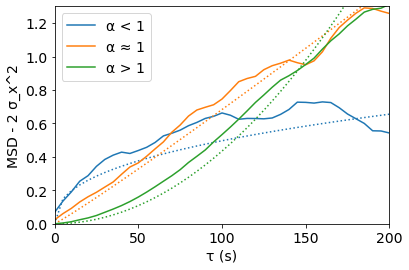

In [13]:
# MSD
def fitfunc(tau, gen_diff, anom_exp):
    return gen_diff * tau ** anom_exp

def plot_msd_fit(msd_curves, fit_params):
    plt.figure()
    ax = plt.gca()
    for curve, fit in zip(msd_curves, fit_params):
        n = len(curve)
        dt = np.arange(0, 5*len(curve), 5)
        if fit[1] < 0.7:
            label = 'α < 1'
        elif fit[1] < 1.33:
            label = 'α ≈ 1'
        else:
            label = 'α > 1'
        color = next(ax._get_lines.prop_cycler)['color']
        plt.plot(dt, curve, label=label, color=color)
        plt.plot(dt[:n//3], fitfunc(dt[:n//3], fit[0], fit[1]), linestyle='dotted', color=color)
    plt.ylim(0, 1.3)
    plt.xlim(0, 200)
    plt.xlabel('τ (s)')
    plt.ylabel('MSD - 2 σ_x^2')
    plt.legend()
    plt.show()
    plt.close()
    
msd_curves = []
fit_params = []
for name, params in data.items():
    with open(os.path.join(params[0], files['msd'])) as file:
        msd_dict = yaml.load(file, Loader=yaml.FullLoader)
    for key, msd_data in msd_dict.items():
        if len(msd_data['msd']) > 100:
            if key in [(3, 3), (57, 1), (49, 0)]:  # Plot one subdiff, diff and superdiff
                msd_curves.append(msd_data['msd'])
                fit_params.append(msd_data['fit'])
plot_msd_fit([msd_curves[1], msd_curves[2], msd_curves[0]], [fit_params[1], fit_params[2], fit_params[0]])

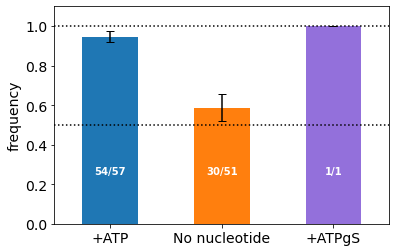

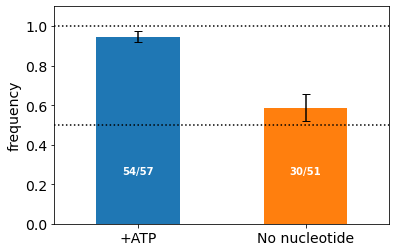

In [14]:
# Plot traces with CPA.
def analyze_segments(cpa_data, labels, colors, edgecolors, ax=None):
    
    n_bins = len(cpa_data)
    same_dir = np.zeros(n_bins)
    n_segments = np.zeros(n_bins)
    
    for i, cpa in enumerate(cpa_data):
        for cpa_fit in cpa:
            x_fit = cpa_fit['x_fit']
            v = cpa_fit['v_fit']
            p = cpa_fit['jumps']
            for p_index in range(len(p) - 2):
                if np.sign(v[p[p_index]]) == np.sign(v[p[p_index + 1]]):
                    same_dir[i] = same_dir[i] + 1
                n_segments[i] = n_segments[i] + 1
    
    fracs = same_dir / n_segments
    errs = np.sqrt(fracs * (1 - fracs) / n_segments)
    
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(n_bins):
        text = '{}/{}'.format(int(same_dir[i]), int(n_segments[i]))
        plt.bar([i], [fracs[i]], yerr=[errs[i]], color=colors[i], 
                linewidth=1.5, capsize=4, ecolor='k', width=0.5)
        plt.text(i, 0.25, text, horizontalalignment='center', color='white', size=10, weight='bold')
    ax.set_ylim(0, 1.1)
    ax.set_xticks(np.arange(n_bins))
    ax.set_xticklabels(labels)
    ax.set_ylabel('frequency')
    ax.plot([-0.5, n_bins - 0.5], [0.5, 0.5], c='k', linestyle='dotted')
    # ax.text(n_bins - 0.45, 0.5, 'random \nmotion', verticalalignment='center', size=10)
    ax.plot([-0.5, n_bins - 0.5], [1, 1], c='k', linestyle='dotted')
    # ax.text(n_bins - 0.45, 1, 'unidirectional \nmotion', verticalalignment='center', size=10)
    ax.set_xlim(-0.5, n_bins -0.5)
    if ax is None:
        plt.title('Consecutive CPA segments \nwith the same direction')
        plt.show()
        plt.close()
    
cpa_data = []
labels = []
colors = []
edgecolors = []
for name, params in data.items():
    cpa = []
    df_motion = pd.read_csv(os.path.join(params[0], files['motion']))
    with open(os.path.join(params[0], files['cpa'])) as file:
        cpa_dict = yaml.load(file, Loader=yaml.FullLoader)
    for i, row in df_motion.iterrows():
        if bool(row['moving']):
            cpa.append(cpa_dict[(int(row['scan_id']), int(row['trace_id']))])
    if len(cpa) > 5:
        cpa_data.append(cpa)
        labels.append(name)
        colors.append(params[1])
        edgecolors.append(params[2])
            
analyze_segments(cpa_data, labels, colors, edgecolors)

cpa_data = []
labels = []
colors = []
edgecolors = []
for name, params in data.items():
    cpa = []
    df_motion = pd.read_csv(os.path.join(params[0], files['motion']))
    with open(os.path.join(params[0], files['cpa'])) as file:
        cpa_dict = yaml.load(file, Loader=yaml.FullLoader)
    for i, row in df_motion.iterrows():
        if bool(row['moving']):
            cpa.append(cpa_dict[(int(row['scan_id']), int(row['trace_id']))])
    if len(cpa) > 10:
        cpa_data.append(cpa)
        labels.append(name)
        colors.append(params[1])
        edgecolors.append(params[2])
            
analyze_segments(cpa_data, labels, colors, edgecolors)

In [15]:
# Timelapse of frames.
def plot_timelapse(im, filename=None, ax=None):
    n_frames = im.shape[0]
    frame_freq = 5
    spacer = 5
    contrast = [0, 5, 0]

    timelapse = np.ones(((im.shape[1] + spacer) * int(1 + n_frames / frame_freq), im.shape[2], im.shape[3]))
    for i, frame in enumerate(im[::frame_freq]):
        loc = i * (im.shape[1] + spacer)
        timelapse[loc:loc+im.shape[1], :, :] = np.clip(contrast * im[i * frame_freq, :, :, :] / np.amax(im), 0, 1)
    timelapse = timelapse.swapaxes(0, 1)


    xticks = [im.shape[1] / 2 + i * (im.shape[1] + spacer) for i in range(1 + int(n_frames / frame_freq))]
    xticks_labels = [5 * frame_freq * i for i in range(len(xticks))]
    
    
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.pcolorfast(timelapse)
    ax.set_aspect('equal')
    ax.set_xlabel('t (s)')
    ax.set_yticks([])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks_labels)
    ax.plot([14, 14], [4, 24], c='w', linewidth=4)
    ax.text(8, 14, '1 um', rotation=90, c='w', fontsize=9, verticalalignment='center',weight='bold')
    if ax is None:
        if filename is not None:
            plt.savefig('test.pdf', dpi=600)
        plt.show()
        plt.close()

In [16]:
# Plot tiff.
tiff_path = r'figure_data/20210707-140655 DNA2_R Marker 2_scan7.tiff'
im = io.imread(tiff_path)
im.shape

(87, 18, 160, 3)

Text(0, 0.5, 'x (px)')

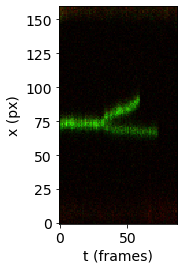

In [17]:
# Kymograph.
kymo = np.sum(im, axis=1).swapaxes(0, 1)
plt.imshow(kymo / np.amax(kymo), origin='lower', interpolation="nearest")
plt.xlabel('t (frames)')
plt.ylabel('x (px)')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


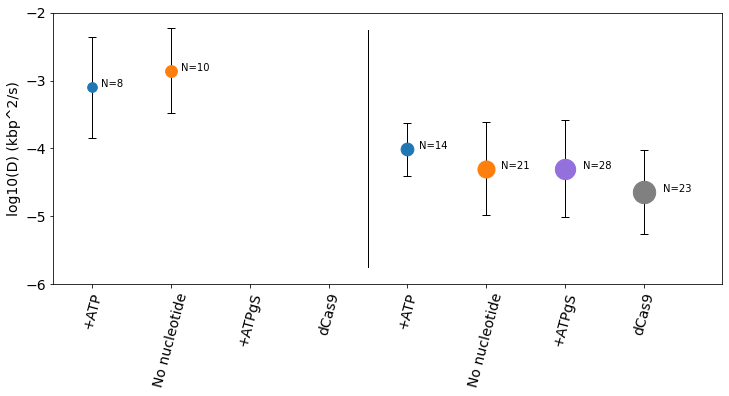

In [18]:
# Diffusion coefficients of diffusive and static traces

def plot_diff_vs_cond_with_static(title, means, stds, sizes, colors, counts, labels, ax=None):
    n = len(means)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=[12, 5])
    ax.errorbar(np.arange(n), means, yerr=stds, linewidth=0, elinewidth=1, capsize=4, c='k', zorder=1)
    for i in range(8):
        ax.scatter([i], [means[i]], c=colors[i], s=500 * sizes[i], zorder=2)
        ax.text(i + np.sqrt(sizes[i])/4, means[i], 'N='+str(counts[i]), fontsize=10)
    ax.set_ylabel('log10(D) (kbp^2/s)')
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(labels, rotation=75)
    ax.set_ylabel('log10(D) (kbp^2/s)')
    ax.set_xlim(-0.5, n)
    ax.set_ylim(-6, -2)
    ax.set_yticks(np.arange(-2,-6.5,-1)) 
    ax.plot([3.5, 3.5], [-5.75, -2.25], c='k', linewidth=1)
    if ax is None:
        plt.title(title)
        plt.show()
        plt.close()
    
# Compile data.
means = []
stds = []
sizes = []
colors = []
labels = []
counts = []
for name, params in data.items():
    df_motion = pd.read_csv(os.path.join(params[0], files['motion']))
    df_moving = df_motion[df_motion['moving']==True]  
    
    
    df_diff = df_moving[(df_moving['alpha'] >= 0.5) & (df_moving['alpha'] < 1.5)]
    labels.append(name)
        
    colors.append(params[1])
    means.append(np.log10(df_diff['diffusion (kbp**2/s)']).mean())
    stds.append(np.log10(df_diff['diffusion (kbp**2/s)']).std())
    sizes.append(len(df_diff) / len(df_motion))
    counts.append(len(df_diff))

for name, params in data.items():
    df_motion = pd.read_csv(os.path.join(params[0], files['motion']))
    df_static = df_motion[df_motion['moving']==False]  
    
    df_diff = df_static
    labels.append(name)
        
    colors.append(params[1])
    means.append(np.log10(df_diff['diffusion (kbp**2/s)']).mean())
    stds.append(np.log10(df_diff['diffusion (kbp**2/s)']).std())
    sizes.append(len(df_diff) / len(df_motion))
    counts.append(len(df_diff))
    
    
plot_diff_vs_cond_with_static('D for diffusive and static spots', means, stds, sizes, colors, counts, labels)

C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


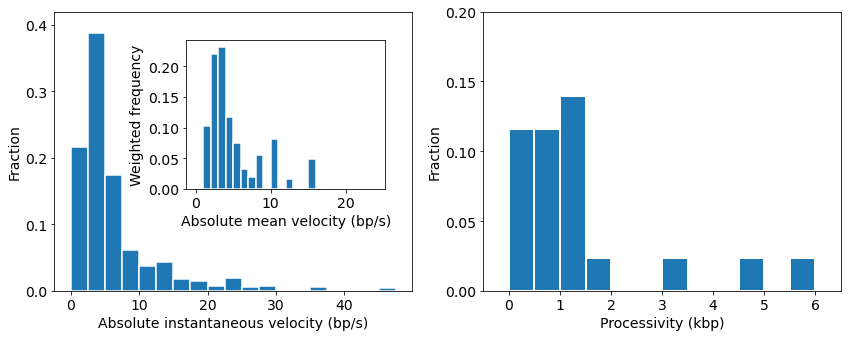

In [19]:
# Figure 4.
fig = plt.figure(figsize=(12, 9))
gs = matplotlib.gridspec.GridSpec(2, 2)

# Get data
name = '+ATP'
params = data[name]
df = pd.read_csv(os.path.join(params[0], files['motion']))
with open(os.path.join(params[0], files['cpa'])) as file:
    cpa_dict = yaml.load(file, Loader=yaml.FullLoader)
    
# Panel A
ax1 = fig.add_subplot(gs[0, 0])
plot_abs_velocity(df, cpa_dict, name, params[1], params[2], ax1, ymax=0.42)

# Inset to ax1.
ax1sp = fig.add_axes([0.225, 0.695, 0.23, 0.23])
plot_abs_mean_velocity_nonstatic(df, cpa_dict, name, params[1], params[2], ax1sp)

# Panel B
ax2 = fig.add_subplot(gs[0, 1])
plot_processivity(df, name, params[1], params[2], ax2)

# Panel C
# ax3 = fig.add_subplot(gs[1, :])
# plot_timelapse(im, ax=ax3)

# Finish up and save.
plt.tight_layout()
# plt.savefig('Figure4.pdf', dpi=600)
plt.show()
plt.close()

C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


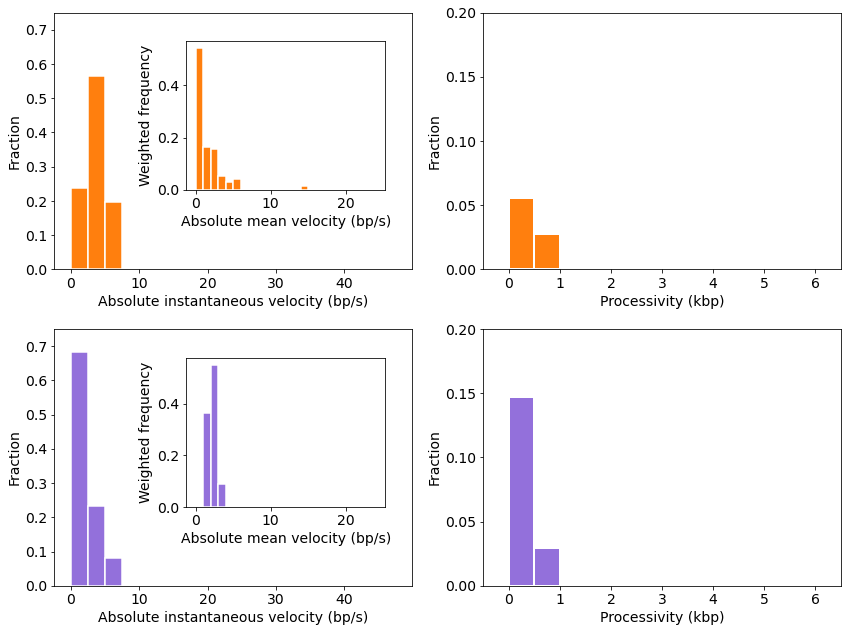

In [20]:
# Figure S8.
fig = plt.figure(figsize=(12, 9))
gs = matplotlib.gridspec.GridSpec(2, 2)

# Get data
name1 = 'No nucleotide'
params1 = data[name1]
df1 = pd.read_csv(os.path.join(params1[0], files['motion']))
with open(os.path.join(params1[0], files['cpa'])) as file:
    cpa_dict1 = yaml.load(file, Loader=yaml.FullLoader)
name2 = '+ATPgS'
params2 = data[name2]
df2 = pd.read_csv(os.path.join(params2[0], files['motion']))
with open(os.path.join(params2[0], files['cpa'])) as file:
    cpa_dict2 = yaml.load(file, Loader=yaml.FullLoader)
    
# Panel A
ax1 = fig.add_subplot(gs[0, 0])
plot_abs_velocity(df1, cpa_dict1, name1, params1[1], params1[2], ax1, ymax=0.75)

# Inset to ax1.
ax1sp = fig.add_axes([0.225, 0.695, 0.23, 0.23])
plot_abs_mean_velocity_nonstatic(df1, cpa_dict1, name1, params1[1], params1[2], ax1sp)

# Panel B
ax2 = fig.add_subplot(gs[0, 1])
plot_processivity(df1, name1, params1[1], params1[2], ax2)

# Panel C
ax3 = fig.add_subplot(gs[1, 0])
plot_abs_velocity(df2, cpa_dict2, name2, params2[1], params2[2], ax3, ymax=0.75)

# Inset to ax3.
ax3sp = fig.add_axes([0.225, 0.695-0.49, 0.23, 0.23])
plot_abs_mean_velocity_nonstatic(df2, cpa_dict2, name2, params2[1], params2[2], ax3sp)

# Panel D
ax4 = fig.add_subplot(gs[1, 1])
plot_processivity(df2, name2, params2[1], params2[2], ax4)

# Finish up and save.
plt.tight_layout()
# plt.savefig('FigureS8.pdf')
plt.show()
plt.close()

[0.3255814  0.02325581 0.18604651 0.46511628] [0.07145956 0.02298381 0.05934393 0.07606349]
0 / 43  uncategorized
[0.58333333 0.05555556 0.27777778 0.08333333] [0.08216777 0.0381769  0.07465053 0.04606423]
0 / 36  uncategorized
[0.82352941 0.         0.         0.17647059] [0.0653787 0.        0.        0.0653787]
0 / 34  uncategorized
[1. 0. 0. 0.] [0. 0. 0. 0.]
0 / 23  uncategorized


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


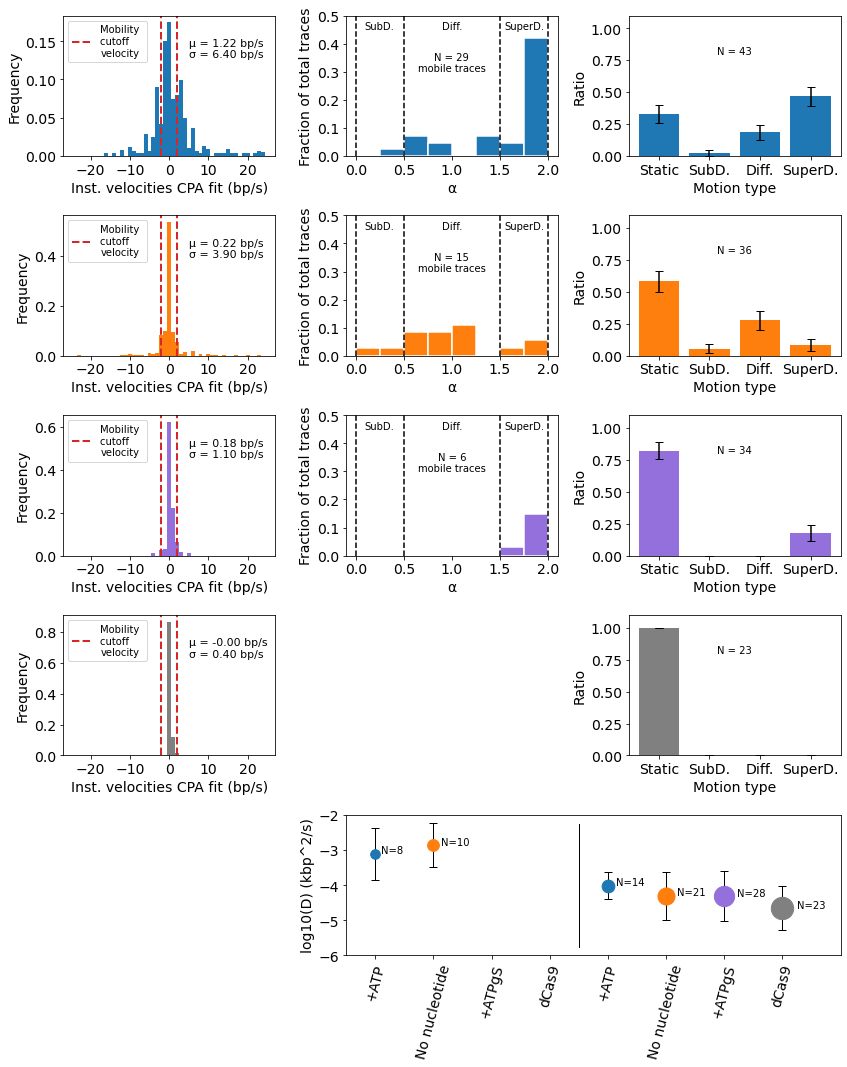

In [21]:
# Figure S6.
fig = plt.figure(figsize=(12, 15))
gs = matplotlib.gridspec.GridSpec(5, 3)

# Get data
name0 = '+ATP'
params0 = data[name0]
df0 = pd.read_csv(os.path.join(params0[0], files['motion']))
with open(os.path.join(params0[0], files['cpa'])) as file:
    cpa_dict0 = yaml.load(file, Loader=yaml.FullLoader)
name1 = 'No nucleotide'
params1 = data[name1]
df1 = pd.read_csv(os.path.join(params1[0], files['motion']))
with open(os.path.join(params1[0], files['cpa'])) as file:
    cpa_dict1 = yaml.load(file, Loader=yaml.FullLoader)
name2 = '+ATPgS'
params2 = data[name2]
df2 = pd.read_csv(os.path.join(params2[0], files['motion']))
with open(os.path.join(params2[0], files['cpa'])) as file:
    cpa_dict2 = yaml.load(file, Loader=yaml.FullLoader)
name3 = 'dCas9'
params3 = data[name3]
df3 = pd.read_csv(os.path.join(params3[0], files['motion']))
with open(os.path.join(params3[0], files['cpa'])) as file:
    cpa_dict3 = yaml.load(file, Loader=yaml.FullLoader)
    
# Panel A
ax1 = fig.add_subplot(gs[0, 0])
plot_cpa_velocity_all(df0, cpa_dict0, name0, params0[1], params0[2], ax1)
# ax1.set_xlabel("")
ax2 = fig.add_subplot(gs[0, 1])
plot_alpha(df0, name0, params0[1], params0[2], ax2)
# ax2.set_xlabel("")
ax3 = fig.add_subplot(gs[0, 2])
plot_motion_type_histogram(df0, name0, params0[1], params0[2], ax3)
# ax3.set_xticklabels(["", "", "", ""])

ax4 = fig.add_subplot(gs[1, 0])
plot_cpa_velocity_all(df1, cpa_dict1, name1, params1[1], params1[2], ax4)
# ax4.set_xlabel("")
ax5 = fig.add_subplot(gs[1, 1])
plot_alpha(df1, name1, params1[1], params1[2], ax5)
# ax5.set_xlabel("")
ax6 = fig.add_subplot(gs[1, 2])
plot_motion_type_histogram(df1, name1, params1[1], params1[2], ax6)
# ax6.set_xticklabels(["", "", "", ""])

ax7 = fig.add_subplot(gs[2, 0])
plot_cpa_velocity_all(df2, cpa_dict2, name2, params2[1], params2[2], ax7)
# ax7.set_xlabel("")
ax8 = fig.add_subplot(gs[2, 1])
plot_alpha(df2, name2, params2[1], params2[2], ax8)
ax9 = fig.add_subplot(gs[2, 2])
plot_motion_type_histogram(df2, name2, params2[1], params2[2], ax9)
# ax9.set_xticklabels(["", "", "", ""])

ax10 = fig.add_subplot(gs[3, 0])
plot_cpa_velocity_all(df3, cpa_dict3, name3, params3[1], params3[2], ax10)
# ax8 = fig.add_subplot(gs[2, 1])
ax11 = fig.add_subplot(gs[3, 2])
plot_motion_type_histogram(df3, name3, params3[1], params3[2], ax11)

ax12 = fig.add_subplot(gs[4, 1:3])
plot_diff_vs_cond_with_static('D for diffusive and static spots', means, stds, sizes, colors, counts, labels, ax=ax12)

# Finish up and save.
plt.tight_layout()
# plt.savefig('FigureS6.pdf')
plt.show()
plt.close()

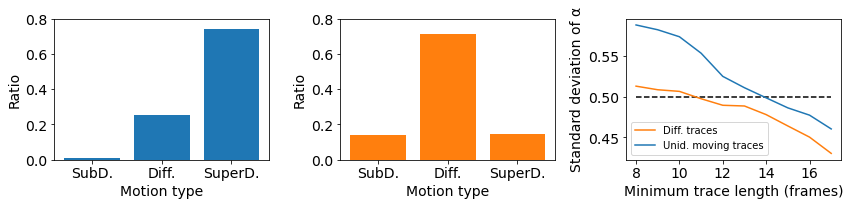

In [22]:
# Figure S4.

# Simulated data; see simulations.ipynb.
df_sim = pd.read_csv(r'figure_data/simulated/min_L_vs_alpha_error_D0p0013_v0p005_sig0p072_halfnormal_1000samples_tM0p33.csv')
xlabels = ['SubD.', 'Diff.', 'SuperD.']
bars_diffusive = [0.13902439024390245, 0.7121951219512195, 0.14878048780487804]
bars_moving = [0.009852216748768473, 0.2512315270935961, 0.7389162561576355]



fig = plt.figure(figsize=(12, 3))
gs = matplotlib.gridspec.GridSpec(1, 3)
    
# Panel A
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(xlabels, bars_moving, color=data['+ATP'][1])
ax1.set_xlabel('Motion type')
ax1.set_ylabel('Ratio')
ax1.set_ylim(0, 0.8)

# Panel B
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(xlabels, bars_diffusive, color=data['No nucleotide'][1])
ax2.set_xlabel('Motion type')
ax2.set_ylabel('Ratio')
ax2.set_ylim(0, 0.8)

# Panel C
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot([8, 17], [0.5, 0.5], c='k', linestyle='dashed')
ax3.plot(df_sim['trace length (frames)'], df_sim['sigma alpha diffusive'], color=data['No nucleotide'][1], label='Diff. traces')
ax3.plot(df_sim['trace length (frames)'], df_sim['sigma alpha moving'], color=data['+ATP'][1], label='Unid. moving traces')
ax3.legend(fontsize=10)
ax3.set_xlabel('Minimum trace length (frames)')
ax3.set_ylabel('Standard deviation of α')

# Finish up and save.
plt.tight_layout()
# plt.savefig('FigureS4.pdf')
plt.show()
plt.close()

[0.03448276 0.27586207 0.68965517] [0.03388301 0.08299609 0.08590912]
0 / 43  uncategorized
[0.13333333 0.66666667 0.2       ] [0.08777075 0.12171612 0.10327956]
0 / 36  uncategorized


C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


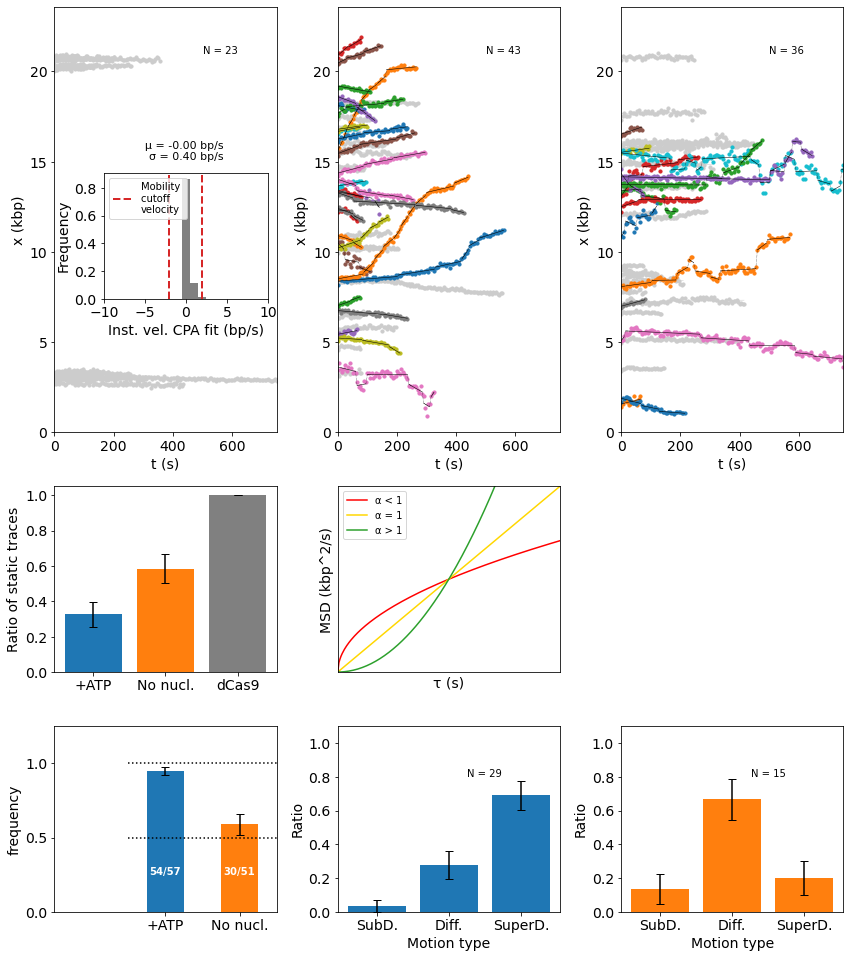

In [23]:
# Figure 2.

# Get data
name0 = '+ATP'
params0 = data[name0]
df0 = pd.read_csv(os.path.join(params0[0], files['motion']))
df_traces0 = pd.read_csv(os.path.join(params0[0], files['traces']))
static_ratio0 = 0.3255814
static_err0 = 0.07145956
n0 = 43
with open(os.path.join(params0[0], files['cpa'])) as file:
    cpa_dict0 = yaml.load(file, Loader=yaml.FullLoader)
name1 = 'No nucleotide'
params1 = data[name1]
df1 = pd.read_csv(os.path.join(params1[0], files['motion']))
df_traces1 = pd.read_csv(os.path.join(params1[0], files['traces']))
static_ratio1 = 0.58333333
static_err1 = 0.08216777
n1 = 36
with open(os.path.join(params1[0], files['cpa'])) as file:
    cpa_dict1 = yaml.load(file, Loader=yaml.FullLoader)
name2 = '+ATPgS'
params2 = data[name2]
df2 = pd.read_csv(os.path.join(params2[0], files['motion']))
df_traces2 = pd.read_csv(os.path.join(params2[0], files['traces']))
static_ratio2 = 0.82352941
static_err2 = 0.0653787
n2 = 34
with open(os.path.join(params2[0], files['cpa'])) as file:
    cpa_dict2 = yaml.load(file, Loader=yaml.FullLoader)
name3 = 'dCas9'
params3 = data[name3]
df3 = pd.read_csv(os.path.join(params3[0], files['motion']))
df_traces3 = pd.read_csv(os.path.join(params3[0], files['traces']))
static_ratio3 = 1
static_err3 = 0
n3 = 23
with open(os.path.join(params3[0], files['cpa'])) as file:
    cpa_dict3 = yaml.load(file, Loader=yaml.FullLoader)

# Consecutive segment data
cpa_data = []
labels = []
colors = []
edgecolors = []
for name, params in data.items():
    cpa = []
    df_motion = pd.read_csv(os.path.join(params[0], files['motion']))
    with open(os.path.join(params[0], files['cpa'])) as file:
        cpa_dict = yaml.load(file, Loader=yaml.FullLoader)
    for i, row in df_motion.iterrows():
        if bool(row['moving']):
            cpa.append(cpa_dict[(int(row['scan_id']), int(row['trace_id']))])
    if len(cpa) > 10:
        cpa_data.append(cpa)
        labels.append(name)
        colors.append(params[1])
        edgecolors.append(params[2])
    
# Start figure.
fig = plt.figure(figsize=(12, 13.5))
gs = matplotlib.gridspec.GridSpec(4, 3)  # , wspace=0.3, hspace=0.3)
    
# a, b, c
ax1 = fig.add_subplot(gs[0:2, 0])
plot_cpa(df3, df_traces3, cpa_dict3, name3, ax1)
ax2 = fig.add_subplot(gs[0:2, 1])
plot_cpa(df0, df_traces0, cpa_dict0, name0, ax2)
ax3 = fig.add_subplot(gs[0:2, 2])
plot_cpa(df1, df_traces1, cpa_dict1, name1, ax3)

# Inset to ax1.
ax1sp = fig.add_axes([0.128, 0.685, 0.19, 0.13])
plot_cpa_velocity_all(df3, cpa_dict3, name3, params3[1], params3[2], ax1sp, text='above')
ax1sp.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax1sp.set_xlim(-10, 10)
ax1sp.set_xticks([-10, -5, 0, 5, 10])
ax1sp.set_xlabel("Inst. vel. CPA fit (bp/s)")

# d, e
ax4 = fig.add_subplot(gs[2, 0])
ax4.bar(np.arange(3), [static_ratio0, static_ratio1, static_ratio3], yerr=[static_err0, static_err1, static_err3], 
        capsize=4, color=[params0[1], params1[1], params3[1]])
ax4.set_ylabel('Ratio of static traces')
ax4.set_xticks(np.arange(3))
ax4.set_xticklabels(['+ATP', 'No nucl.', 'dCas9'])
ax4.set_yticks(np.arange(0, 1.1, 0.2))
ax5 = fig.add_subplot(gs[3, 0])
analyze_segments(cpa_data, labels, colors, edgecolors, ax5)
ax5.set_ylim([0, 1.25])
ax5.set_yticks([0, 0.5, 1])
ax5.set_xlim([-1.5, 1.5])
ax5.set_xticklabels(['+ATP', 'No nucl.'])

# f
ax6 = fig.add_subplot(gs[2, 1])
color=['tab:green','red','gold']
x=(np.linspace(0,100,10000)) 
diff=10*x
subdiff=10*x**(1/2)
superdiff=10*x**(2)
ax6.plot(x,subdiff, label = 'α < 1', color='red')
ax6.plot(x,diff, label = 'α = 1', color='gold')
ax6.plot(x,superdiff, label = 'α > 1', color='tab:green')
ax6.set_ylim(0, 20)
ax6.set_xlim(0, 2)
ax6.set_xlabel('τ (s)')
ax6.set_ylabel('MSD (kbp^2/s)')
ax6.tick_params(axis='x', which='both',bottom=False, top=False,labelbottom=False)
ax6.tick_params(axis='y', which='both',right=False, left=False,labelleft=False)
ax6.legend(fontsize=10)

# g, h
ax7 = fig.add_subplot(gs[3, 1])
plot_motion_type_histogram(df0, name0, params0[1], params0[2], ax7, mobile_only=True)
ax7.set_yticks(np.arange(0, 1.1, 0.2))
ax8 = fig.add_subplot(gs[3, 2])
plot_motion_type_histogram(df1, name1, params1[1], params1[2], ax8, mobile_only=True)
ax8.set_yticks(np.arange(0, 1.1, 0.2))

# Finish up and save.
plt.tight_layout(pad=1, h_pad=1.08)
# plt.savefig('Figure2.pdf')
plt.show()
plt.close()

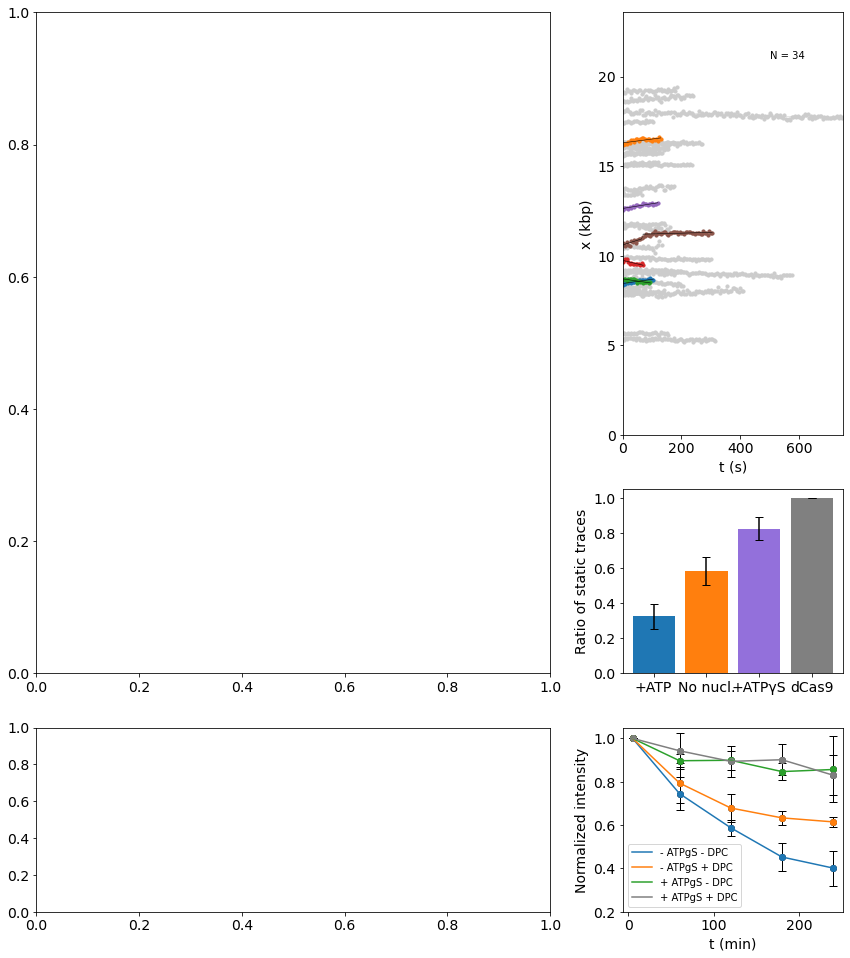

In [24]:
# Figure 3.

# Data.
densitometries_path = os.path.join(repository_directory, r'Raw bulk data\Protein gels\Fig. 4d-e\Densitometry all gels.csv')
df_densitometries = pd.read_csv(densitometries_path)
sample_means_std=[]
for sample, df_sample_number in df_densitometries.groupby('Sample'):
    for timepoint, df_timepoint in df_sample_number.groupby('Time (min)'): 
        time=timepoint
        avg=np.mean(df_timepoint['Normalized to 5 min'])
        st_dev=np.std(df_timepoint['Normalized to 5 min'])
        sample_means_std.append([sample, time, avg, st_dev])
sample_means_std_np=np.array(sample_means_std)

# Start figure.
fig = plt.figure(figsize=(12, 13.5))
gs = matplotlib.gridspec.GridSpec(4, 3)
_ = fig.add_subplot(gs[0:3, 0:2])
_ = fig.add_subplot(gs[3, 0:2])

# b
ax1 = fig.add_subplot(gs[0:2, 2])
plot_cpa(df2, df_traces2, cpa_dict2, name2, ax1)

# c
ax2 = fig.add_subplot(gs[2, 2])
ax2.bar(np.arange(4), [static_ratio0, static_ratio1, static_ratio2, static_ratio3], 
        yerr=[static_err0, static_err1, static_err2, static_err3], 
        capsize=4, color=[params0[1], params1[1], params2[1], params3[1]])
ax2.set_ylabel('Ratio of static traces')
ax2.set_xticks(np.arange(4))
ax2.set_xticklabels(['+ATP', 'No nucl.', '+ATPγS', 'dCas9'])
ax2.set_yticks(np.arange(0, 1.1, 0.2))

# e
ax3 = fig.add_subplot(gs[3, 2])
ax3.scatter(sample_means_std_np[0:5,1],sample_means_std_np[0:5,2], color='tab:blue', linewidth=1, zorder=2)
ax3.scatter(sample_means_std_np[5:10,1],sample_means_std_np[5:10,2], color='tab:orange', linewidth=1, zorder=2)
ax3.scatter(sample_means_std_np[10:15,1],sample_means_std_np[10:15,2], color='tab:green', linewidth=1, zorder=2)
ax3.scatter(sample_means_std_np[15:20,1],sample_means_std_np[15:20,2], color='tab:gray', linewidth=1, zorder=2)
ax3.errorbar(sample_means_std_np[0:5,1],sample_means_std_np[0:5,2], yerr=sample_means_std_np[0:5,3], linewidth=1, capsize=4, fmt='o', color='black', zorder=1)
ax3.errorbar(sample_means_std_np[5:10,1],sample_means_std_np[5:10,2], yerr=sample_means_std_np[5:10,3], linewidth=1,capsize=4, fmt='o', color='black', zorder=1)
ax3.errorbar(sample_means_std_np[10:15,1],sample_means_std_np[10:15,2], yerr=sample_means_std_np[10:15,3], linewidth=1, capsize=4, fmt='o',  color='black', zorder=1)
ax3.errorbar(sample_means_std_np[15:20,1],sample_means_std_np[15:20,2], yerr=sample_means_std_np[15:20,3], linewidth=1, capsize=4, fmt='o', color='black', zorder=1)
ax3.plot(sample_means_std_np[0:5,1],sample_means_std_np[0:5,2], color='tab:blue')
ax3.plot(sample_means_std_np[5:10,1],sample_means_std_np[5:10,2], color='tab:orange')
ax3.plot(sample_means_std_np[10:15,1],sample_means_std_np[10:15,2], color='tab:green')
ax3.plot(sample_means_std_np[15:20,1],sample_means_std_np[15:20,2], color='tab:gray')
ax3.legend(['- ATPgS - DPC','- ATPgS + DPC','+ ATPgS - DPC','+ ATPgS + DPC'], fontsize=10)
ax3.set_xlabel('t (min)')
ax3.set_ylabel('Normalized intensity')
ax3.set_ylim(0.2, 1.05)

# Finish up and save.
plt.tight_layout(pad=1, h_pad=1.08)
# plt.savefig('Figure3.pdf')
plt.show()
plt.close()

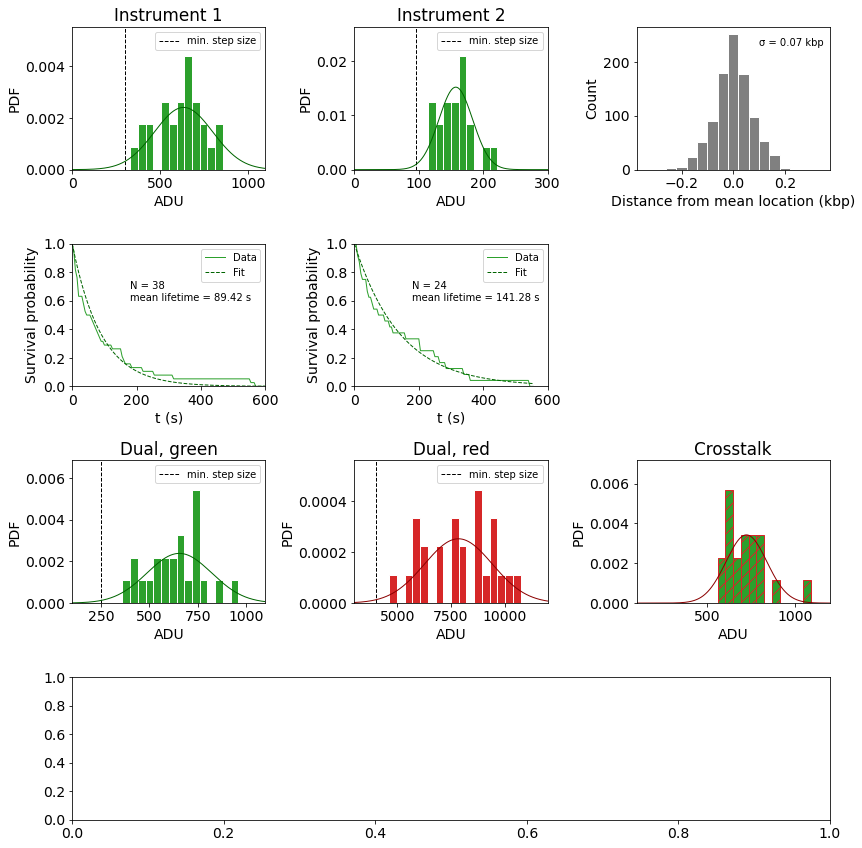

In [27]:
# Figure S3
from scipy.stats import norm

# Data.
fig_data_path = os.path.join(repository_directory,
                             r'Raw single-molecule data\Single color experiments\dCas9',
                             r'Fluorophore callibration data\Instrument 1\C_dCas9_I_calibration.yaml')
with open(fig_data_path) as file:
    ctrap_intensity = yaml.load(file, Loader=yaml.FullLoader)['step size dist']
fig_data_path = os.path.join(repository_directory,
                             r'Raw single-molecule data\Single color experiments\dCas9',
                             r'Fluorophore callibration data\Instrument 1\C_dCas9_lifetime_all data.yaml')
with open(fig_data_path) as file:
    ctrap_lifetime = yaml.load(file, Loader=yaml.FullLoader)['lifetime (s)']
fig_data_path = os.path.join(repository_directory,
                             r'Raw single-molecule data\Single color experiments\dCas9',
                             r'Fluorophore callibration data\Instrument 2\Q_dCas9_I_calibration.yaml')
with open(fig_data_path) as file:
    qtrap_intensity = yaml.load(file, Loader=yaml.FullLoader)['step size dist']
fig_data_path = os.path.join(repository_directory,
                             r'Raw single-molecule data\Single color experiments\dCas9',
                             r'Fluorophore callibration data\Instrument 2\Q_dCas9_lifetime_all data.yaml')
with open(fig_data_path) as file:
    qtrap_lifetime = yaml.load(file, Loader=yaml.FullLoader)['lifetime (s)']
fig_data_path = os.path.join(repository_directory,
                             r'Raw single-molecule data\Two color experiments\dCas9\callibration_data_G_fluo_RG_lasers.yaml')
with open(fig_data_path) as file:
    dual_green = yaml.load(file, Loader=yaml.FullLoader)['step size dist']
fig_data_path = os.path.join(repository_directory,
                             r'Raw single-molecule data\Two color experiments\dCas9\callibration_data_R_fluo_RG_lasers.yaml')
with open(fig_data_path) as file:
    dual_red = yaml.load(file, Loader=yaml.FullLoader)['step size dist']
fig_data_path = os.path.join(repository_directory,
                             r'Raw single-molecule data\Two color experiments\dCas9\callibration_data_R_crosstalk_RG_lasers.yaml')
with open(fig_data_path) as file:
    dual_crosstalk = yaml.load(file, Loader=yaml.FullLoader)['step size dist']
    
# Measurement error.
df_dcas9_filtered = pd.read_csv(os.path.join(data['dCas9'][0], files['traces']))
errors = np.array([])
for i, scan in df_dcas9_filtered.groupby('scan_id'):
    for j, trace in scan.groupby('trace_id'):
        errors = np.concatenate((errors, trace['x_kbp'] - trace['x_kbp'].mean()))
        
    
def plot_step_sizes_custom(data, n_bins, min_step_size, ax, lims=(0, 1100), 
                           color='tab:green', fitcolor='darkgreen', legend=True, hatch=False):

    # Make fig.
    lower_bound_x=lims[0]
    upper_bound_x=lims[1]
    hist, bin_edges = np.histogram(data['step_sizes'], bins=n_bins, range=lims)
    bins = np.array([(bin_edges[i + 1] + bin_edges[i]) / 2 for i in range(len(bin_edges) - 1)])
    
    ax.hist(data['step_sizes'], bins=bins, color=color, edgecolor='white', density=True)
    if hatch:
        ax.hist(data['step_sizes'], bins=bins, color=color, edgecolor='tab:red', density=True, hatch="//")
    ax.axvline(min_step_size, c='black', linestyle='dashed', linewidth=1)
    x = np.linspace(lower_bound_x, upper_bound_x, 1000)
    ax.plot(x, norm.pdf(x, data['mean'], data['std']), color=fitcolor, linewidth=1)
    ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    if legend:
        ax.legend(['min. step size'], loc='upper right', fontsize=10)
#     ax.text(ax.get_xlim()[1]*0.7, ax.get_ylim()[1]*0.7,
#             'N = %i\nmean = %.1f ADU\nstd = %.1f ADU' % (data['n_steps'], data['mean'], data['std']),
#             fontsize=10)
    ax.set_xlabel('step size (ADU)')
    ax.set_xlim(lims)
    ax.set_xlabel('ADU')
    ax.set_ylabel('PDF')


def plot_lifetime_custom(data, color, xlim, ylim, ax):

    # Make fig.
    ax.plot(data['xvals'], data['yvals'], color=color, linewidth=1, label='Data')
    ax.plot(data['xvals'], data['yfit'], color='darkgreen', linestyle='dashed', label='Fit', linewidth=1)
    ax.text(180, 0.6,
            'N = ' + str(data['count'])+  "\nmean lifetime = %.2f " % data['mean_lifetime'] + data['t_unit'],
            fontsize=10)
    ax.set_xlabel('t (' + data['t_unit'] + ')')
    ax.set_ylabel('Survival probability')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(fontsize=10)


fig = plt.figure(figsize=(12, 12))
gs = matplotlib.gridspec.GridSpec(4, 3)

ax1 = fig.add_subplot(gs[0, 0])
plot_step_sizes_custom(ctrap_intensity, 25, 300, ax1, lims=(0, 1100))
ax1.set_title('Instrument 1')
ax2 = fig.add_subplot(gs[1, 0])
plot_lifetime_custom(ctrap_lifetime, 'tab:green', (0, 600), (0, 1), ax2)

ax3 = fig.add_subplot(gs[0, 1])
plot_step_sizes_custom(qtrap_intensity, 25, 95, ax3, lims=(0, 300))
ax3.set_title('Instrument 2')
ax4 = fig.add_subplot(gs[1, 1])
plot_lifetime_custom(qtrap_lifetime, 'tab:green', (0, 600), (0, 1), ax4)

ax5 = fig.add_subplot(gs[2, 0])
plot_step_sizes_custom(dual_green, 25, 250, ax5, lims=(100, 1100))
ax5.set_title('Dual, green')
ax6 = fig.add_subplot(gs[2, 1])
plot_step_sizes_custom(dual_red, 25, 4000, ax6, lims=(3000, 12000), color='tab:red', fitcolor='darkred')
ax6.set_title('Dual, red')
ax7 = fig.add_subplot(gs[2, 2])
ax7.set_title('Crosstalk')
plot_step_sizes_custom(dual_crosstalk, 25, 0, ax7, lims=(100, 1200), legend=False, hatch=True, fitcolor='darkred')

ax8 = fig.add_subplot(gs[0, 2])
bins = np.arange(-0.34, 0.38, 0.04)
ax8.hist(errors, bins=bins, color=data['dCas9'][1], edgecolor=data['dCas9'][2], linewidth=1)
ax8.set_xlabel('Distance from mean location (kbp)')
ax8.set_ylabel('Count')
ax8.text(0.1, 230, "σ = 0.07 kbp", fontsize=10)
# plt.title('Measurement error dCas9: %.2f kbp' % np.std(errors))

_ = fig.add_subplot(gs[3, :])

plt.tight_layout()
# plt.savefig('FigureS3.pdf')
plt.show()
plt.close()

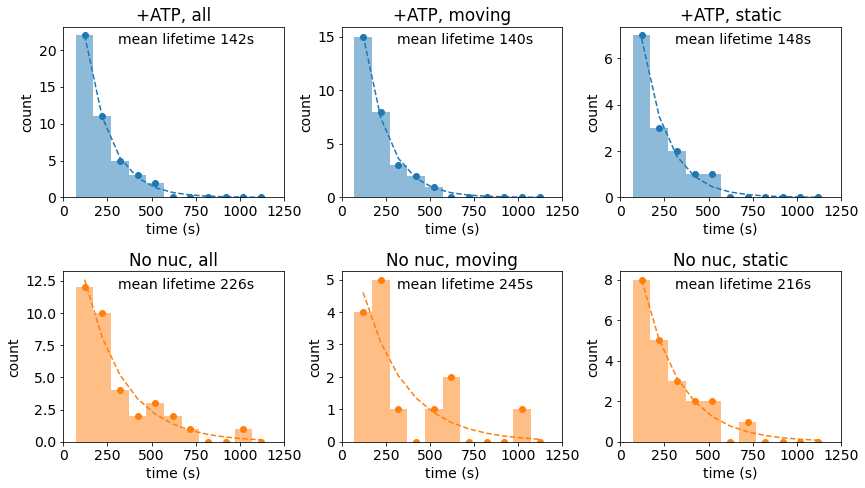

In [28]:
from scipy.optimize import curve_fit


# Do single exponent fit.
def single_exp_decay(x, a, c):
    return c * np.exp(- x / a)


def fit_mean_lifetime(xvals, yvals):
    params, cov = curve_fit(single_exp_decay, xvals, yvals, p0=(50, 10))
    yfit = single_exp_decay(xvals, *params)
    return params[0], yfit


def plot_lifetimes(df, color, ax, binsize=20*5, xlim=250*5):
    bins = np.arange(14*5, xlim, binsize) + 0.5
    xdata = bins[:-1] + binsize/2
    ydata, _ = np.histogram(5*df['lifetime'], bins=bins)
    ax.bar(xdata, ydata, color=color, width=binsize, alpha=0.5)
    ax.scatter(xdata, ydata, color=color)
    mean_lifetime, yfit = fit_mean_lifetime(xdata, ydata)
    ax.plot(xdata, yfit, linestyle='dashed', color=color)
    ax.text(xlim*0.25, ax.get_ylim()[1]*0.9, 'mean lifetime %.0fs' % mean_lifetime)
    ax.set_xlim((0, xlim))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('count')
    

# Extra figure with ATP / no nuc lifetimes.
fig = plt.figure(figsize=(12, 7))
gs = matplotlib.gridspec.GridSpec(2, 3)

# Get data
name1 = '+ATP'
params1 = data[name1]
df1 = pd.read_csv(os.path.join(params1[0], files['motion']))
with open(os.path.join(params1[0], files['cpa'])) as file:
    cpa_dict1 = yaml.load(file, Loader=yaml.FullLoader)
name2 = 'No nucleotide'
params2 = data[name2]
df2 = pd.read_csv(os.path.join(params2[0], files['motion']))
with open(os.path.join(params2[0], files['cpa'])) as file:
    cpa_dict2 = yaml.load(file, Loader=yaml.FullLoader)
    
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('+ATP, all')
plot_lifetimes(df1, params1[1], ax1)
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('+ATP, moving')
plot_lifetimes(df1[df1['moving'] == 1], params1[1], ax2)
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title('+ATP, static')
plot_lifetimes(df1[df1['moving'] == 0], params1[1], ax3)

ax4 = fig.add_subplot(gs[1, 0])
ax4.set_title('No nuc, all')
plot_lifetimes(df2, params2[1], ax4)
ax5 = fig.add_subplot(gs[1, 1])
ax5.set_title('No nuc, moving')
plot_lifetimes(df2[df2['moving'] == 1], params2[1], ax5)
ax6 = fig.add_subplot(gs[1, 2])
ax6.set_title('No nuc, static')
plot_lifetimes(df2[df2['moving'] == 0], params2[1], ax6)

# Finish up and save.
plt.tight_layout()
# plt.savefig('ExtraFigureLifetimes.pdf')
plt.show()
plt.close()

C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


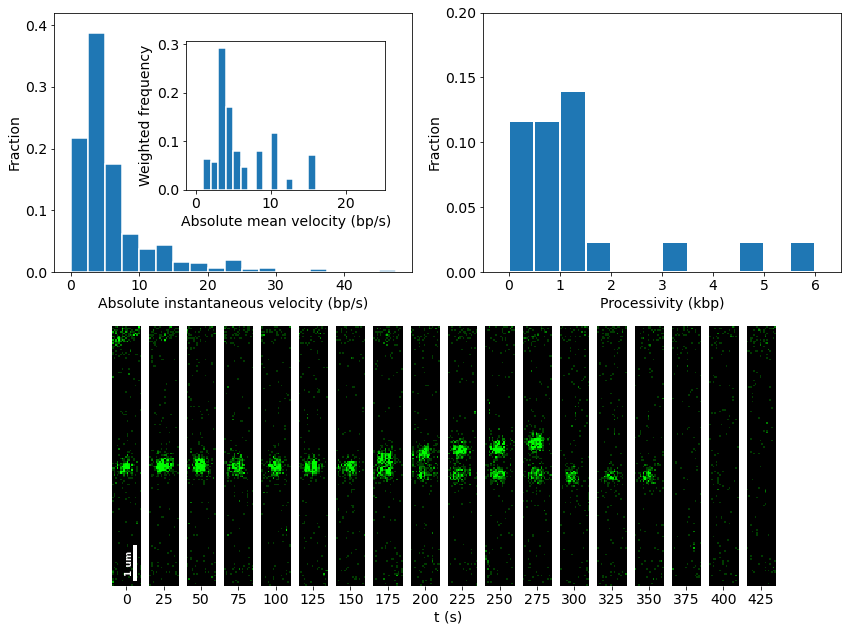

In [29]:
# Figure 4, version 2 (alpha >= 1.5)
fig = plt.figure(figsize=(12, 9))
gs = matplotlib.gridspec.GridSpec(2, 2)

# Get data
name = '+ATP'
params = data[name]
df = pd.read_csv(os.path.join(params[0], files['motion']))
with open(os.path.join(params[0], files['cpa'])) as file:
    cpa_dict = yaml.load(file, Loader=yaml.FullLoader)
    
# Panel A
ax1 = fig.add_subplot(gs[0, 0])
plot_abs_velocity(df, cpa_dict, name, params[1], params[2], ax1, ymax=0.42)

# Inset to ax1.
ax1sp = fig.add_axes([0.225, 0.695, 0.23, 0.23])
plot_abs_mean_velocity(df, cpa_dict, name, params[1], params[2], ax1sp)

# Panel B
ax2 = fig.add_subplot(gs[0, 1])
plot_processivity(df, name, params[1], params[2], ax2)

# Panel C
ax3 = fig.add_subplot(gs[1, :])
plot_timelapse(im, ax=ax3)

# Finish up and save.
plt.tight_layout()
# plt.savefig('Figure4_alphaGE1p5.pdf', dpi=600)
plt.show()
plt.close()

C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


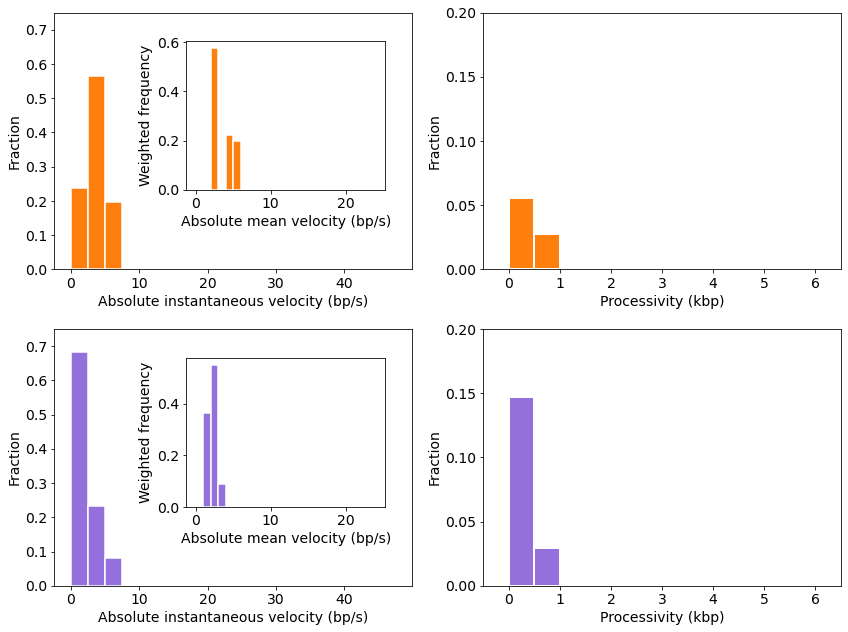

In [30]:
# Figure S8, version 2 (alpha >= 1.5)
fig = plt.figure(figsize=(12, 9))
gs = matplotlib.gridspec.GridSpec(2, 2)

# Get data
name1 = 'No nucleotide'
params1 = data[name1]
df1 = pd.read_csv(os.path.join(params1[0], files['motion']))
with open(os.path.join(params1[0], files['cpa'])) as file:
    cpa_dict1 = yaml.load(file, Loader=yaml.FullLoader)
name2 = '+ATPgS'
params2 = data[name2]
df2 = pd.read_csv(os.path.join(params2[0], files['motion']))
with open(os.path.join(params2[0], files['cpa'])) as file:
    cpa_dict2 = yaml.load(file, Loader=yaml.FullLoader)
    
# Panel A
ax1 = fig.add_subplot(gs[0, 0])
plot_abs_velocity(df1, cpa_dict1, name1, params1[1], params1[2], ax1, ymax=0.75)

# Inset to ax1.
ax1sp = fig.add_axes([0.225, 0.695, 0.23, 0.23])
plot_abs_mean_velocity(df1, cpa_dict1, name1, params1[1], params1[2], ax1sp)

# Panel B
ax2 = fig.add_subplot(gs[0, 1])
plot_processivity(df1, name1, params1[1], params1[2], ax2)

# Panel C
ax3 = fig.add_subplot(gs[1, 0])
plot_abs_velocity(df2, cpa_dict2, name2, params2[1], params2[2], ax3, ymax=0.75)

# Inset to ax3.
ax3sp = fig.add_axes([0.225, 0.695-0.49, 0.23, 0.23])
plot_abs_mean_velocity(df2, cpa_dict2, name2, params2[1], params2[2], ax3sp)

# Panel D
ax4 = fig.add_subplot(gs[1, 1])
plot_processivity(df2, name2, params2[1], params2[2], ax4)

# Finish up and save.
plt.tight_layout()
# plt.savefig('FigureS8_alphaGE1p5.pdf')
plt.show()
plt.close()